In [3]:
import numpy as np
import math
import pylab as pl
import res_utils as ru
from tqdm import tqdm

In [4]:
# Functions for trajectory generation

mu = 0
sigma = 330
b_ = 0.13
dt = 0.1
min_distance = 0.03
rho_rh = 0.25
scene = 0.5
t = 2
num_samples = int(t/dt)

scale = 20

# Inputs:
# scene - contains description of the environment
# num_samples - number of samples to take

# Outputs:
# Position: Array of position vectors
# Velocity: Array of velocities


def distance_from_wall(position, direction_vector, scene):

    x = position[0]
    y = position[1]
    # 0=left, 1=right, 2=top, 3=down
    dists = np.array([x, scene-x, y, scene-y])
    distance_wall = np.min(dists)

    closest_wall = np.argmin(dists)
    if closest_wall == 1:
        normal = np.array([1, 0])
    elif closest_wall == 0:
        normal = np.array([-1, 0])
    elif closest_wall == 3:
        normal = np.array([0, 1])
    elif closest_wall == 2:
        normal = np.array([0, -1])

    angle_wall = math.acos(np.dot(direction_vector, normal))

    return [distance_wall, angle_wall]


def turn(direction_vector, angle, dt):
    new_angle = np.arctan2(
        direction_vector[1], direction_vector[0]) + dt*np.deg2rad(angle)
    return np.array([np.cos(new_angle), np.sin(new_angle)])


def generate_rat_trajectory(scene, num_samples, start_location):

    random_turn = np.random.normal(mu, sigma, num_samples)
    random_velocity = np.random.rayleigh(b_, num_samples)

    v = random_velocity[0]
    direction_vector = np.array(
        [np.cos(np.deg2rad(random_turn[0])), np.sin(np.deg2rad(random_turn[0]))])

    position = np.zeros((num_samples, 2))
    position[0, :] = start_location
    velocity = np.zeros((num_samples, 2))
    velocity[0, :] = v*direction_vector

    for i in range(1, num_samples):
        dist_and_angle = distance_from_wall(
            position[i-1, :], direction_vector, scene)
        distance_wall = dist_and_angle[0]
        angle_wall = dist_and_angle[1]

        if distance_wall < min_distance and np.abs(angle_wall) < np.pi/2:
            angle = np.sign(angle_wall) * \
                (np.pi/2-np.abs(angle_wall)) + random_turn[i]
            v = (1-rho_rh)*v
        else:
            angle = random_turn[i]
            v = random_velocity[i]

        position[i, :] = position[i-1, :] + direction_vector*v*dt
        velocity[i, :] = direction_vector*v*dt

        if position[i, 0] < 0:
            diff = np.abs(position[i, 0])
            velocity[i, 0] -= diff
            position[i, 0] = 0
        if position[i, 0] > scene:
            diff = np.abs(position[i, 0]-scene)
            velocity[i, 0] -= diff
            position[i, 0] = scene
        if position[i, 1] < 0:
            diff = np.abs(position[i, 1])
            velocity[i, 1] -= diff
            position[i, 1] = 0
        if position[i, 1] > scene:
            diff = np.abs(position[i, 1]-scene)
            velocity[i, 1] -= diff
            position[i, 1] = scene

        if position[i, 0] < 0 or position[i, 0] > scene or position[i, 1] < 0 or position[i, 1] > scene:
            print("OUTSIDE BOUNDARIES: t=" + str(i*dt))

        direction_vector = turn(direction_vector, angle, dt)

    return [position, velocity]

Text(0.5, 1.0, 'Trajectory')

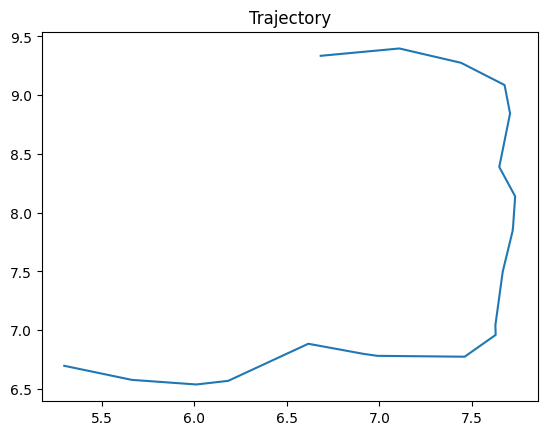

In [5]:
# Generate a trajectory


start_location = np.random.uniform(0, scene, 2)
results = generate_rat_trajectory(scene, num_samples, start_location)

position = results[0]*scale

fig1, ax1 = pl.subplots()

ax1.plot(position[:, 0], position[:, 1])
ax1.set_title("Trajectory")

**Intrinsic noise on the position vector**

In [6]:
# general parameters
moduli = [3, 5, 7]
n_mods = len(moduli)
N = 5000  # hyper dimension
n_space = 30  # search grid size: n_space*n_space

# noise parameter
kappa = 2

# initialize the result lists
all_est = np.zeros((len(position[:, 0]), 2))
all_est_noise = np.zeros((len(position[:, 0]), 2))
error = []

# generate the random codebook vectors
codebooks = []

# resonator parameters
num_iters = 20

# generate the random codebook vectors
codebooks = []

xvs = []
count = 0
for c in range(3):
    for m, mod in enumerate(moduli):
        codebooks.append(np.zeros((mod, N), dtype='complex'))
        if c == 2:
            xv = xvs[m]**-1*xvs[m+n_mods]**-1
        else:
            xv = ru.cvecl(N, loopsize=mod)
        # xvs = [x1,x2,x3,y1,y2,y3,z1,z2,z3]  for 3 moduli and 3 hexagonal dimensions
        xvs.append(xv)
        for i in range(mod):
            codebooks[count][i, :] = xv**i
        count += 1


for pa in range(len(position[:, 0])):
    xt = position[pa, 0]
    yt = position[pa, 1]

    print("Position: ", position[pa])

    # initialize the resonator
    if pa == 0:
        vec = np.ones(N, dtype='complex')
        vec_noise = np.ones(N, dtype='complex')
        # generate the position vector from the codebook vectors

        # convert the 2D encoding to 3D hexagonal coordinates
        a = np.array([1, 0])
        b = np.array([-1/2, np.sqrt(3)/2,])
        c = np.array([-1/2, -np.sqrt(3)/2])

        r = np.dot(a, np.array([xt, yt]))    # 3D hexagonal coordinates
        s = np.dot(b, np.array([xt, yt]))
        t = np.dot(c, np.array([xt, yt]))
        hex_coord = [r, s, t]
        for ind_ax, axes in enumerate(range(0, n_mods*3, n_mods)):
            for ind, _ in enumerate(moduli):
                vec *= (xvs[axes+ind] ** hex_coord[ind_ax])
                vec_noise *= (xvs[axes+ind] ** hex_coord[ind_ax])

        resonator = np.ones((n_mods*3, N), dtype=complex)
        for i in range(n_mods):
            resonator[i, :] = np.random.normal(0.0, 1.0, size=(
                1, N)) + 1j*np.random.normal(0.0, 1.0, size=(1, N))
            resonator[i, :] = resonator[i, :] / np.abs(resonator[i, :])

    else:  # velocity shift
        velocity = position[pa]-position[pa-1]

        dx0 = velocity[0]
        dy0 = velocity[1]

        a = np.array([1, 0])
        b = np.array([-1/2, np.sqrt(3)/2,])
        c = np.array([-1/2, -np.sqrt(3)/2])

        r = np.dot(a, np.array([dx0, dy0]))  # 3D coordinates
        s = np.dot(b, np.array([dx0, dy0]))
        t = np.dot(c, np.array([dx0, dy0]))

        hex_coord = [r, s, t]

        # initialise the resonator with the previous estimate
        for i in range(n_mods*3):
            resonator[i, :] = res_out[-1][i, :]

        for ind_ax, axes in enumerate(range(0, n_mods*3, n_mods)):
            for ind, _ in enumerate(moduli):
                vec *= (xvs[axes+ind] ** hex_coord[ind_ax])
                vec_noise *= (xvs[axes+ind] ** hex_coord[ind_ax])
                resonator[axes+ind]*=xvs[axes+ind] ** hex_coord[ind_ax] 

    noise = np.exp(1j*np.random.vonmises(mu=0,
                                         kappa=kappa, size=vec.size))
    vec *= noise
    vec_noise *= noise

    # run the resonator
    n_iters, res_out = ru.gen_res_digit(
        resonator, codebooks, num_iters, vec)

    # estimated position vector
    est = np.ones_like(vec, dtype='complex')
    for i in range(3*n_mods):
        est *= res_out[-1][i, :]

    vec = est

    # find the position with the highest similarity to the estimated position
    search_space_x = np.linspace(
        np.min(position[:, 0]), np.max(position[:, 0]), n_space)
    search_space_y = np.linspace(
        np.min(position[:, 1]), np.max(position[:, 1]), n_space)

    simi_pos = np.zeros((n_space, n_space))
    simi_pos_noise = np.zeros((n_space, n_space))
    for u, pos_x in enumerate(search_space_x):
        for v, pos_y in enumerate(search_space_y):
            # 3D hexagonal coordinates
            r = np.dot(a, np.array([pos_x, pos_y]))
            s = np.dot(b, np.array([pos_x, pos_y]))
            t = np.dot(c, np.array([pos_x, pos_y]))
            hex_coord = [r, s, t]
            vec_pos = np.ones(N, dtype='complex')
            for ind_ax, axes in enumerate(range(0, n_mods*3, n_mods)):
                for ind, _ in enumerate(moduli):
                    vec_pos *= (xvs[axes+ind] ** hex_coord[ind_ax])
            simi_pos[u, v] = ru.dot_complex(vec_pos, est)
            simi_pos_noise[u, v] = ru.dot_complex(vec_pos, vec_noise)

    x_ind, y_ind = np.unravel_index(
        np.argmax(simi_pos, axis=None), simi_pos.shape)
    xt_est, yt_est = search_space_x[x_ind], search_space_y[y_ind]

    x_ind_noise, y_ind_noise = np.unravel_index(
        np.argmax(simi_pos_noise, axis=None), simi_pos_noise.shape)
    xt_est_noise, yt_est_noise = search_space_x[x_ind_noise], search_space_y[y_ind_noise]

    all_est[pa] = [xt_est, yt_est]
    all_est_noise[pa] = [xt_est_noise, yt_est_noise]

    print('Estimated position: ', [float(xt_est),float(yt_est)])

    error.append(np.linalg.norm(np.array([xt_est, yt_est]-position[pa])))
    print('Error: ', error[-1])
    print('**********')

Position:  [6.68251932 9.33528647]
Estimated position:  [7.397760233348483, 8.510294386493609]
Error:  1.0918706431661211
**********
Position:  [7.10779594 9.39763653]
Estimated position:  [7.6499566030886035, 9.00326224651065]
Error:  0.6704246860564582
**********
Position:  [7.44151821 9.27564268]
Estimated position:  [7.481825689928523, 9.299042962520875]
Error:  0.046607577137718736
**********
Position:  [7.67669548 9.08645804]
Estimated position:  [7.734022059668644, 9.101855818514057]
Error:  0.059358475605078745
**********
Position:  [7.70641086 8.84410018]
Estimated position:  [7.734022059668644, 8.806075102503833]
Error:  0.04699239270713111
**********
Position:  [7.6479572  8.38917255]
Estimated position:  [7.6499566030886035, 8.4117008144902]
Error:  0.02261681185073525
**********
Position:  [7.73402206 8.13906004]
Estimated position:  [7.734022059668644, 8.115920098479975]
Error:  0.023139938625543977
**********
Position:  [7.72280953 7.88553004]
Estimated position:  [7.734

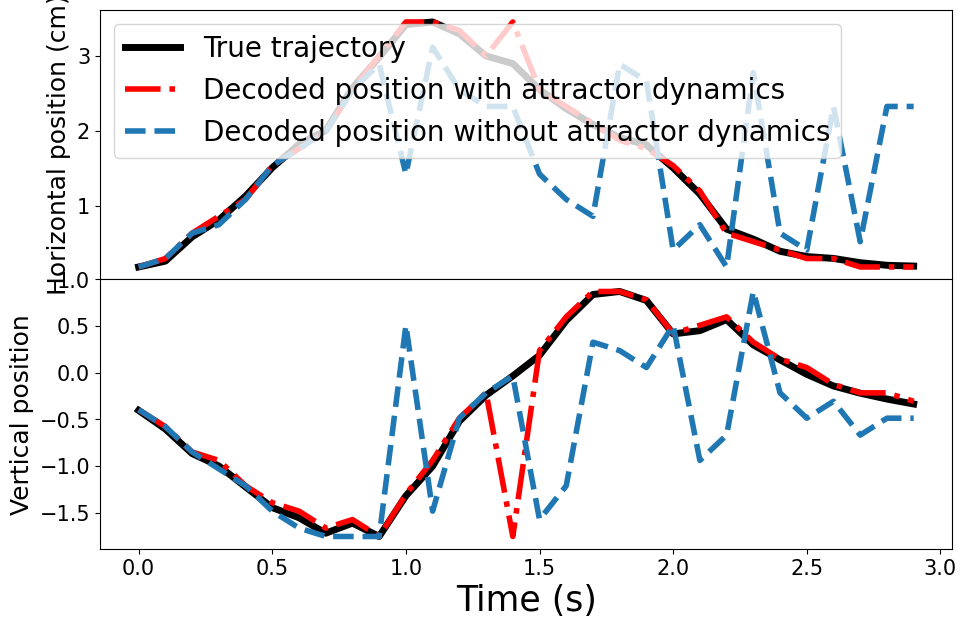

In [11]:
n_position = len(position[:, 0])

gridspec_kw = dict(
    height_ratios=(1, 1),
    hspace=0,
)

fig, axes = pl.subplots(
    nrows=2, ncols=1, sharex=True, gridspec_kw=gridspec_kw, figsize=(11, 7)
)

axes[0].plot(np.arange(n_position),
             position[:, 0], label='True trajectory', linewidth=5, color='black')
axes[0].plot(np.arange(n_position), all_est[:, 0],
             label='Decoded position with attractor dynamics', linewidth=4, linestyle='-.', color='red')
axes[0].plot(np.arange(n_position), all_est_noise[:, 0],
             label='Decoded position without attractor dynamics', linewidth=4, linestyle='--')
axes[0].set_ylabel('Horizontal position (cm)', fontsize=18)

# axes[0].legend(prop={'size': 16})
axes[1].plot(np.arange(n_position),
             position[:, 1]-2, linewidth=5, color='black', label='True trajectory')
axes[1].plot(np.arange(n_position), all_est[:, 1]-2,
             label='Decoded position with attractor dynamics', linewidth=4, linestyle='-.', color='red')
axes[1].plot(np.arange(n_position), all_est_noise[:, 1]-2,
             label='Decoded position without attractor dynamics', linewidth=4, linestyle='--')
axes[1].set_xlabel('Time (s)', fontsize=25)
axes[1].set_ylabel('Vertical position', fontsize=18)
axes[0].set_yticks(np.arange(1, 4))
axes[1].set_xticks(np.arange(0, n_position+1, 5))
axes[1].set_xticklabels(np.arange(0, n_position+1, 5)*dt)
# axes[1].set_xticks(np.array([0, 5, 10, 15, 20, 25, 30]))
# axes[1].set_xticklabels(np.array([0, 5, 10, 15, 20, 25, 30])/10)
axes[0].legend(prop={'size': 20}, loc='upper left')
axes[0].tick_params(axis='both', which='major', labelsize=15)
axes[1].tick_params(axis='both', which='major', labelsize=15)
pl.savefig('path_int_2D', dpi=400)

**Error quantization**

In [1]:
# general parameters
moduli = [3, 5, 7]
n_mods = len(moduli)
N = 2000  # hyper dimension
n_space = 30  # search grid size: n_space*n_space
n_trials = 100

# noise parameter
kappa = 2

# initialize the result lists - _noise is for dynamics whithout attractor error correction
all_est = np.zeros((n_trials,num_samples, 2))
all_est_noise = np.zeros((n_trials, num_samples, 2))
error = np.zeros((n_trials,num_samples))
error_noise = np.zeros((n_trials, num_samples))

# generate the random codebook vectors
codebooks = []

# resonator parameters
num_iters = 20

# generate the random codebook vectors
codebooks = []

xvs = []
count = 0
for c in range(3):
    for m, mod in enumerate(moduli):
        codebooks.append(np.zeros((mod, N), dtype='complex'))
        if c == 2:
            xv = xvs[m]**-1*xvs[m+n_mods]**-1
        else:
            xv = ru.cvecl(N, loopsize=mod)
        # xvs = [x1,x2,x3,y1,y2,y3,z1,z2,z3]  for 3 moduli and 3 hexagonal dimensions
        xvs.append(xv)
        for i in range(mod):
            codebooks[count][i, :] = xv**i
        count += 1

for n_trial in tqdm(range(n_trials)):
    start_location = np.random.uniform(0, scene, 2)
    results = generate_rat_trajectory(scene, num_samples, start_location)
    position = results[0]*scale
    for pa in range(len(position[:, 0])):
        xt = position[pa, 0]
        yt = position[pa, 1]

        # initialize the resonator
        if pa == 0:
            vec = np.ones(N, dtype='complex')
            vec_noise = np.ones(N, dtype='complex')
            # generate the position vector from the codebook vectors

            # convert the 2D encoding to 3D hexagonal coordinates
            a = np.array([1, 0])
            b = np.array([-1/2, np.sqrt(3)/2,])
            c = np.array([-1/2, -np.sqrt(3)/2])

            r = np.dot(a, np.array([xt, yt]))    # 3D hexagonal coordinates
            s = np.dot(b, np.array([xt, yt]))
            t = np.dot(c, np.array([xt, yt]))
            hex_coord = [r, s, t]
            for ind_ax, axes in enumerate(range(0, n_mods*3, n_mods)):
                for ind, _ in enumerate(moduli):
                    vec *= (xvs[axes+ind] ** hex_coord[ind_ax])
                    vec_noise *= (xvs[axes+ind] ** hex_coord[ind_ax])

            resonator = np.ones((n_mods*3, N), dtype=complex)
            for i in range(n_mods):
                resonator[i, :] = np.random.normal(0.0, 1.0, size=(
                    1, N)) + 1j*np.random.normal(0.0, 1.0, size=(1, N))
                resonator[i, :] = resonator[i, :] / np.abs(resonator[i, :])

        else:  # velocity shift
            velocity = position[pa]-position[pa-1]

            dx0 = velocity[0]
            dy0 = velocity[1]

            a = np.array([1, 0])
            b = np.array([-1/2, np.sqrt(3)/2,])
            c = np.array([-1/2, -np.sqrt(3)/2])

            r = np.dot(a, np.array([dx0, dy0]))  # 3D coordinates
            s = np.dot(b, np.array([dx0, dy0]))
            t = np.dot(c, np.array([dx0, dy0]))

            hex_coord = [r, s, t]

            # initialise the resonator with the previous estimate
            for i in range(n_mods*3):
                resonator[i, :] = res_out[-1][i, :]

            for ind_ax, axes in enumerate(range(0, n_mods*3, n_mods)):
                for ind, _ in enumerate(moduli):
                    resonator[i, :]*=(xvs[axes+ind] ** hex_coord[ind_ax])
                    vec *= (xvs[axes+ind] ** hex_coord[ind_ax])
                    vec_noise *= (xvs[axes+ind] ** hex_coord[ind_ax])

        noise = np.exp(1j*np.random.vonmises(mu=0,
                                             kappa=kappa, size=vec.size))
        vec *= noise
        vec_noise *= noise

        # run the resonator
        n_iters, res_out = ru.gen_res_digit(
            resonator, codebooks, num_iters, vec)

        # estimated position vector
        est = np.ones_like(vec, dtype='complex')
        for i in range(3*n_mods):
            est *= res_out[-1][i, :]

        vec = est

        # find the position with the highest similarity to the estimated position
        search_space_x = np.linspace(
            np.min(position[:, 0]), np.max(position[:, 0]), n_space)
        search_space_y = np.linspace(
            np.min(position[:, 1]), np.max(position[:, 1]), n_space)

        simi_pos = np.zeros((n_space, n_space))
        simi_pos_noise = np.zeros((n_space, n_space))
        for u, pos_x in enumerate(search_space_x):
            for v, pos_y in enumerate(search_space_y):
                # 3D hexagonal coordinates
                r = np.dot(a, np.array([pos_x, pos_y]))
                s = np.dot(b, np.array([pos_x, pos_y]))
                t = np.dot(c, np.array([pos_x, pos_y]))
                hex_coord = [r, s, t]
                vec_pos = np.ones(N, dtype='complex')
                for ind_ax, axes in enumerate(range(0, n_mods*3, n_mods)):
                    for ind, _ in enumerate(moduli):
                        vec_pos *= (xvs[axes+ind] ** hex_coord[ind_ax])
                simi_pos[u, v] = ru.dot_complex(vec_pos, est)
                simi_pos_noise[u, v] = ru.dot_complex(vec_pos, vec_noise)

        x_ind, y_ind = np.unravel_index(
            np.argmax(simi_pos, axis=None), simi_pos.shape)
        xt_est, yt_est = search_space_x[x_ind], search_space_y[y_ind]

        x_ind_noise, y_ind_noise = np.unravel_index(
            np.argmax(simi_pos_noise, axis=None), simi_pos_noise.shape)
        xt_est_noise, yt_est_noise = search_space_x[x_ind_noise], search_space_y[y_ind_noise]

        error[n_trial, pa] = np.linalg.norm(
            np.array([xt_est, yt_est]-position[pa]))
        error_noise[n_trial, pa] = np.linalg.norm(
            np.array([xt_est_noise, yt_est_noise]-position[pa]))

NameError: name 'np' is not defined

In [23]:
cumsum = np.zeros(len(position[:, 0])-1)
for n_trial in tqdm(range(200)):
    cumsum_i = np.zeros(len(position[:, 0])-1)
    start_location = np.random.uniform(0, scene, 2)
    results = generate_rat_trajectory(scene, num_samples, start_location)

    position = results[0]
    position = position*scale
    for i in range(len(position[:, 0])-2):
        cumsum_i[i+1] = np.sqrt((position[i, 0]-position[i+1, 0])
                                ** 2+(position[i, 1]-position[i+1, 1])**2)+cumsum_i[i]
    cumsum = cumsum+cumsum_i

100%|██████████| 200/200 [00:00<00:00, 4555.81it/s]


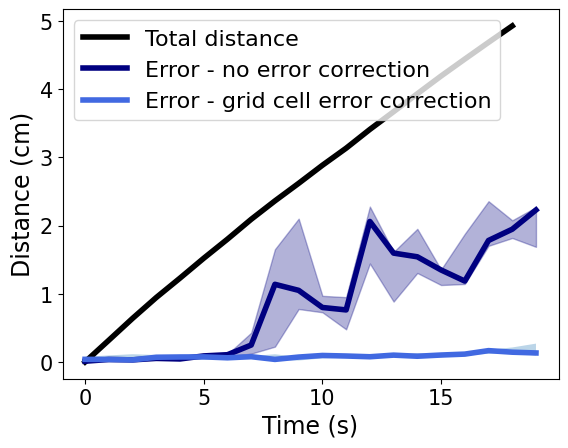

In [24]:
n_pos = len(position[:, 0])
pl.plot(cumsum[:]/200, linewidth=4, label='Total distance', c='black')
pl.plot(np.quantile(error_noise, axis=0, q=0.5),
        linewidth=4, label='Error - no error correction', c='navy')
pl.plot(np.quantile(error, axis=0,
        q=0.5), linewidth=4, label='Error - grid cell error correction', c='royalblue')
pl.fill_between(np.arange(num_samples),np.quantile(error, axis=0, q=0.25),np.quantile(error, axis=0, q=0.75),alpha=0.3)
pl.fill_between(np.arange(num_samples), np.quantile(error_noise, axis=0, q=0.25), np.quantile(
    error_noise, axis=0, q=0.75), alpha=0.3, color='navy')
pl.xlabel('Time (s)', fontsize=17)
pl.ylabel('Distance (cm)', fontsize=17)
pl.legend(prop={'size': 16})
#pl.xticks(np.array([0, 5, 10, 15, 20, 25]),
#          np.array([0, 5, 10, 15, 20, 25])/10)
pl.tick_params(axis='both', which='major', labelsize=15)
pl.tick_params(axis='both', which='major', labelsize=15)

**Receptive Fields visualization**

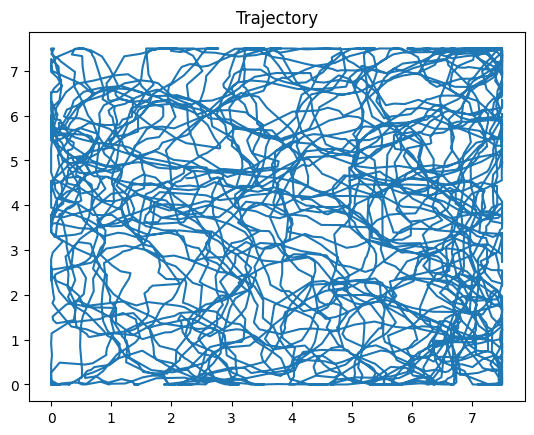

In [40]:
# Generate a trajectory

mu = 0
sigma = 330
b = 0.13
dt = 0.1
min_distance = 0.03
rho_rh = 0.25
scene = 0.5
t = 500.
num_samples = int(t/dt)

scale = 15

start_location = np.random.uniform(0, scene, 2)
results = generate_rat_trajectory(scene, num_samples, start_location)

position = results[0]*scale

fig1, ax1 = pl.subplots()

ax1.plot(position[:, 0], position[:, 1])
ax1.set_title("Trajectory")

# maximum distances travelled in x and y between two time steps

distances_x = np.array([[position[i+1, 0]-position[i, 0]]
                        for i in range(len(position[:, 0])-1)])
distances_x = abs(distances_x)
max_distance_x = np.max(distances_x)

distances_y = np.array([[position[i+1, 1]-position[i, 1]]
                        for i in range(len(position[:, 0])-1)])
distances_y = abs(distances_y)
max_distance_y = np.max(distances_y)

In [41]:
np.random.seed(0)

# moduli parameters
moduli = [3, 5, 7]
n_mods = len(moduli)
N = 10000

# noise parameter
kappa = 0.1
num_iters = 50

# initialize the result lists
all_similarities = []
all_est = []
error = []

# generate the random codebook vectors
codebooks = []

xvs = []
count = 0
for c in range(3):
    for m, mod in enumerate(moduli):
        codebooks.append(np.zeros((mod, N), dtype='complex'))
        if c == 2:
            xv = xvs[m]**-1*xvs[m+n_mods]**-1
        else:
            xv = ru.cvecl(N, loopsize=mod)
        # xvs = [x1,x2,x3,y1,y2,y3,z1,z2,z3]  for 3 moduli and 3 hexagonal dimensions
        xvs.append(xv)
        for i in range(mod):
            codebooks[count][i, :] = xv**i
        count += 1

# generate the HD vectors associated to each of the positions
moduli = np.array(moduli)
n_neurons = np.sum(3*moduli**2-3*moduli+1)
position_vecs = np.zeros((n_neurons, N), dtype='complex')


position_vecs = []
for ind, m in enumerate(moduli):
    position_m = []
    for i in range(m):
        for j in range(m):
            for k in range(m):
                if i == 0 or j == 0 or k == 0:
                    position_m.append(codebooks[ind][i, :] *
                                      codebooks[ind+n_mods][j, :]*codebooks[ind+2*n_mods][k, :])
    position_vecs.append(np.array(position_m))


for pa in tqdm(range(len(position[:, 0]))):
    xt = position[pa, 0]
    yt = position[pa, 1]

    a = np.array([1, 0])
    b = np.array([-1/2, np.sqrt(3)/2,])
    c = np.array([-1/2, -np.sqrt(3)/2])

    r = np.dot(a, np.array([xt, yt]))  # 3D coordinates
    s = np.dot(b, np.array([xt, yt]))
    t = np.dot(c, np.array([xt, yt]))

    vec = np.ones(N, dtype='complex')
    hex_coord = [r, s, t]
    for ind_ax, axes in enumerate(range(0, n_mods*3, n_mods)):
        for ind, _ in enumerate(moduli):
            vec *= (xvs[axes+ind] ** hex_coord[ind_ax])

    # initialize the resonator
    if pa == 0:
        # convert the 2D encoding to 3D hexagonal coordinates
        a = np.array([1, 0])
        b = np.array([-1/2, np.sqrt(3)/2,])
        c = np.array([-1/2, -np.sqrt(3)/2])

        r = np.dot(a, np.array([xt, yt]))    # 3D hexagonal coordinates
        s = np.dot(b, np.array([xt, yt]))
        t = np.dot(c, np.array([xt, yt]))
        hex_coord = [r, s, t]
        for ind_ax, axes in enumerate(range(0, n_mods*3, n_mods)):
            for ind, _ in enumerate(moduli):
                vec *= (xvs[axes+ind] ** hex_coord[ind_ax])

        resonator = np.ones((n_mods*3, N), dtype=complex)
        for i in range(n_mods):
            resonator[i, :] = np.random.normal(0.0, 1.0, size=(
                1, N)) + 1j*np.random.normal(0.0, 1.0, size=(1, N))
            resonator[i, :] = resonator[i, :] / np.abs(resonator[i, :])

    else:  # velocity shift
        velocity = position[pa]-position[pa-1]

        x0 = velocity[0]
        y0 = velocity[1]

        a = np.array([1, 0])
        b = np.array([-1/2, np.sqrt(3)/2,])
        c = np.array([-1/2, -np.sqrt(3)/2])

        r = np.dot(a, np.array([x0, y0]))  # 3D coordinates
        s = np.dot(b, np.array([x0, y0]))
        t = np.dot(c, np.array([x0, y0]))

        hex_coord = [r, s, t]

        for ind_ax, axes in enumerate(range(0, n_mods*3, n_mods)):
            for ind, _ in enumerate(moduli):
                resonator[i, :] *= (xvs[axes+ind] ** hex_coord[ind_ax])
                vec = vec*resonator[i, :]

    n_iters, res_out = ru.gen_res_digit(
        resonator, position_vecs, num_iters, vec)
    res_hist = res_out

    est = np.ones_like(vec, dtype='complex')
    for i in range(len(res_out[-1][:, 0])):
        est *= res_out[-1][i, :]

    # Compute the similarity between the estimated position vector and the fixed point vectors
    similarities = []
    for i in range(len(moduli)):
        position_m = position_vecs[i]
        similarities_m = np.zeros(len(position_m), dtype=complex)
        for p in range(len(position_m)):
            similarities_m[p] = ru.dot_complex(
                res_out[-1][i, :], position_m[p])
        similarities.append(similarities_m)

    all_similarities.append(similarities)

100%|██████████| 5000/5000 [05:19<00:00, 15.64it/s]


/var/folders/gw/_bny03z95mj9kfmrz3p2v6fh0000gp/T/ipykernel_14014/3297287323.py:6: ComplexWarning: Casting complex values to real discards the imaginary part
  neur_val[i] = all_similarities[i][n_module][neuron_idx]
/var/folders/gw/_bny03z95mj9kfmrz3p2v6fh0000gp/T/ipykernel_14014/3297287323.py:11: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colormap = pl.cm.get_cmap('viridis')


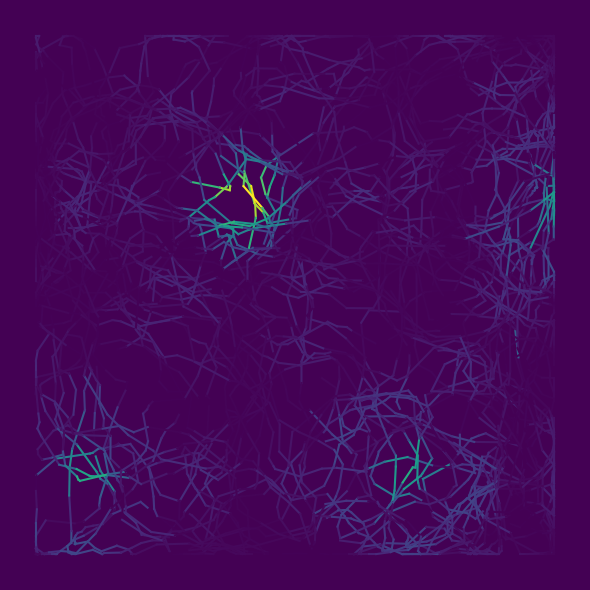

In [85]:
# module number and neuron index in this module
n_module = 2
neuron_idx = 5

neur_val = np.zeros((len(position[:, 0]),))
for i in range(len(position[:, 0])):
    neur_val[i] = all_similarities[i][n_module][neuron_idx]

neur_val = (neur_val-np.min(neur_val))/(np.max(neur_val)-np.min(neur_val))

colormap = pl.cm.get_cmap('viridis')


fig, ax = pl.subplots(figsize=(6, 6), facecolor=colormap(0))

for i in range(len(position[:, 0])-1):
    im = ax.plot([position[i, 0], position[i+1, 0]],
                 [position[i, 1], position[i+1, 1]], c=colormap(neur_val[i]))

ax.axis('off')
pl.title('Receptive fields')
pl.tight_layout()
pl.savefig('figures/mod22')